# Surfing Waves with Sentinel-2: Cross-Spectra & Wavelets on HEALPix Patches

This notebook is a hands-on demo showing how to build **wave spectra** from Sentinel-2 imagery over the ocean using **two 10 m bands** - **B02 (blue)** and **B04 (red)** - that are acquired with a small time offset. That slight offset means the sea surface evolves just enough between the two snapshots to unlock **cross-spectral** estimation: we can both **reduce spectral bias** and **recover wave phase and directions** from the **cross-spectrum**.

Instead of classic FFTs on planar tiles, we resample to a **HEALPix** grid so that all patches share the **same surface per pixel**, then estimate spectra with **wavelets**, which are more robust to noise under the assumption that wave spectra are relatively smooth.

---

## Why B02 x B04 Cross-Spectrum?

- Natural temporal offset: B02 and B04 are acquired a few moments apart. Waves evolve slightly - enough to introduce measurable phase differences while maintaining coherence.
- Cross-spectral benefits:
  - Bias reduction in spectral estimates (compared to single-band autospectra).
  - Phase retrieval -> directions: the cross-spectrum’s complex phase gives propagation directions of waves.
- 10 m resolution: fine enough to resolve short waves; the short offset keeps coherence high at these scales.

---

## Processing Overview

1. **Input**: Sentinel-2 Level-2A/Level-1C oceanic granules containing **B02** and **B04** at **10 m**.  
2. **Patch building (UTM)**: Cut the UTM imagery into fixed **256x256 pixel** patches (~ 2.56 km on a side).  
3. **UTM -> HEALPix**: Resample each patch onto a **HEALPix** grid so that each pixel covers the **same area** regardless of latitude.  
   *Why?* Fair comparisons of spectral energy require consistent pixel areas.  
4. **Wavelet-based spectra**: On the HEALPix patch, compute **wavelet transforms** of B02 and B04 and form the **cross-spectrum**:  
   - Smoother, less noise-sensitive than FFTs in this setting.  
   - Provides **amplitude** (power) and **phase** (direction).  
5. **Direction estimation**: Use the **phase** of the cross-spectrum to infer **wave directions** (and optionally phase speed proxies where applicable).  
6. **Scaling up with xbatcher**: Demonstrate how **xbatcher** can tile large scenes and compute many spectra efficiently across lots of Sentinel-2 data.

---

## What You Will Learn

- How to construct UTM **patches** and resample them to **HEALPix** while preserving radiometry.  
- How to compute **wavelet cross-spectra** between B02 and B04 to:  
  - Reduce estimation bias,  
  - Retrieve **directional** information from **phase**.  
- How to use **xbatcher** to scale the workflow (thousands of patches, large scenes).

---

## Notebook Structure

### 1) From UTM Tiles to HEALPix Patches
- **Load** Sentinel-2 B02 & B04 (10 m).  
- **Window** into **256x256** UTM patches over ocean.  
- **Resample** each patch to **HEALPix** (choose `nside` to match resolution/area).  
- **Validate** area equivalence and basic QC checks (land mask, clouds if needed).

### 2) Wavelet Cross-Spectrum on HEALPix
- **Wavelet transform** (per orientation/scale) on both bands.  
- Build **cross-spectrum** as B02 x conj(B04) across **scales** and **orientations**.  
- **Amplitude** -> spectral energy; **phase** -> **wave direction**.  
- **Visualize**:  
  - 2D spectral maps (k-space-like),  
  - Directional roses,  
  - Scale–orientation slices.

### 3) Scaling with xbatcher
- Use **xbatcher** to generate patch windows automatically.  
- Compute **spectra lazily** (e.g., with Dask) and track progress.  
- Aggregate summary products (mean spectra, dominant direction maps, QC flags).

---

## Why Wavelets (Instead of FFTs)?

- Locality in both scale and space helps suppress noise and edge effects.  
- Ocean wave spectra are smooth; wavelets exploit this by emphasizing coherent structures.  
- Better behaved for irregular sampling after **UTM -> HEALPix** resampling.

---

## Practical Notes

- **Band pairing**: Ensure **B02/B04** are radiometrically harmonized (e.g., same masks, scaled units).  
- **Time offset**: The small acquisition lag is a feature, not a bug - enables phase-based direction retrieval.  
- **HEALPix choice**: Pick an `nside` that approximates **10 m** pixels in area (trade-off between fidelity and cost).  
- **Window size**: **256x256** in UTM balances spectral resolution and stationarity.  
- **Compute**: Use **Dask + xbatcher** to parallelize; persist intermediate HEALPix patches if reusing.

---

## Outputs

- **Per-patch spectra**: amplitude and phase across **scales** and **orientations**.  
- **Directional diagnostics**: dominant **wave direction** and spread.  
- **Summary maps** (optional): mosaicked fields of dominant direction/energy.

---

## (Optional) Reproducibility Checklist

- Sentinel-2 L1C/L2A reader (e.g., `rasterio`/`xarray`).  
- HEALPix utilities (e.g., `healpy` or a custom resampler).  
- Wavelet library or custom implementation for **scale–orientation** analysis.  
- `xbatcher` + `dask` for scalable tiling and compute.  
- Plotting: `matplotlib`, optional `cartopy` for geographic overviews.

---

*This demo is an end-to-end recipe: from Sentinel-2 UTM tiles to HEALPix patches, then to robust wave **cross-spectra** via **wavelets**, finishing with a scalable pipeline using **xbatcher**.*

In [1]:
import xarray as xr
import pystac_client
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client

client = Client()
client

<Client: 'tcp://127.0.0.1:41251' processes=5 threads=20, memory=15.47 GiB>

In [3]:
# Access cloud-optimized Sentinel-2 data via the EOPF STAC catalog
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")

# Define oceanographic study area and time window
LON, LAT = -4.5, 48  # Bay of Biscay - known for consistent wave patterns
date = "2025-06-17/2025-06-17"

# Search criteria optimized for wave analysis
collections = ["sentinel-2-l1c"]
items = list(
    catalog.search(
        datetime=date,
        collections=collections,
        intersects=dict(type="Point", coordinates=[LON, LAT]),
        query={
            "eo:cloud_cover": {
                "lt": 20
            },  # Cloud cover < 20% ensures clear ocean surface
            "view:sun_elevation": {
                "gt": 25
            },  # Filter for high sun elevation > 25° (→ sun zenith angle < 65°),
            # which places the sun near the zenith.
        },
    ).items()
)

for item in items:
    print(f"✅ {item.id}")
else:
    print("No items found for the given criteria.")

✅ S2B_MSIL1C_20250617T112109_N0511_R037_T30UUU_20250617T131418
No items found for the given criteria.


In [4]:
item = items[0]

In [5]:
# Open the dataset lazily from object storage
dt = xr.open_datatree(
    item.assets["product"].href,
    **item.assets["product"].extra_fields["xarray:open_datatree_kwargs"],
)

dt["measurements"]["reflectance"]["r10m"]["b02"]

<xarray.DataArray 'b02' (y: 10980, x: 10980)> Size: 964MB
dask.array<open_dataset-b02, shape=(10980, 10980), dtype=float64, chunksize=(5490, 5490), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
  * y        (y) int64 88kB 5399995 5399985 5399975 ... 5290225 5290215 5290205
Attributes: (12)

In [6]:
import pyproj

crs_code = dt.attrs["other_metadata"]["horizontal_CRS_code"]

# Option 1: let pyproj parse the whole string
src_crs = pyproj.CRS.from_string(crs_code)

# Option 2: strip the prefix and give only the integer
# src_crs = pyproj.CRS.from_epsg(int(crs_code.split(":")[-1]))

transformer = pyproj.Transformer.from_crs(
    src_crs,
    pyproj.CRS.from_epsg(4326),
    always_xy=True
)

In [7]:
size=slice(2*1830,3*1830)
ds=dt["measurements"]["reflectance"]["r10m"].isel(x=size,y=size).persist()
ds

<xarray.DataTree 'r10m'>
Group: /
    Dimensions:  (y: 1830, x: 1830)
    Coordinates:
      * x        (x) int64 15kB 336605 336615 336625 336635 ... 354875 354885 354895
      * y        (y) int64 15kB 5363395 5363385 5363375 ... 5345125 5345115 5345105
    Data variables:
        b02      (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
        b03      (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
        b04      (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
        b08      (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>

Text(0.5, 1.0, 'b04')

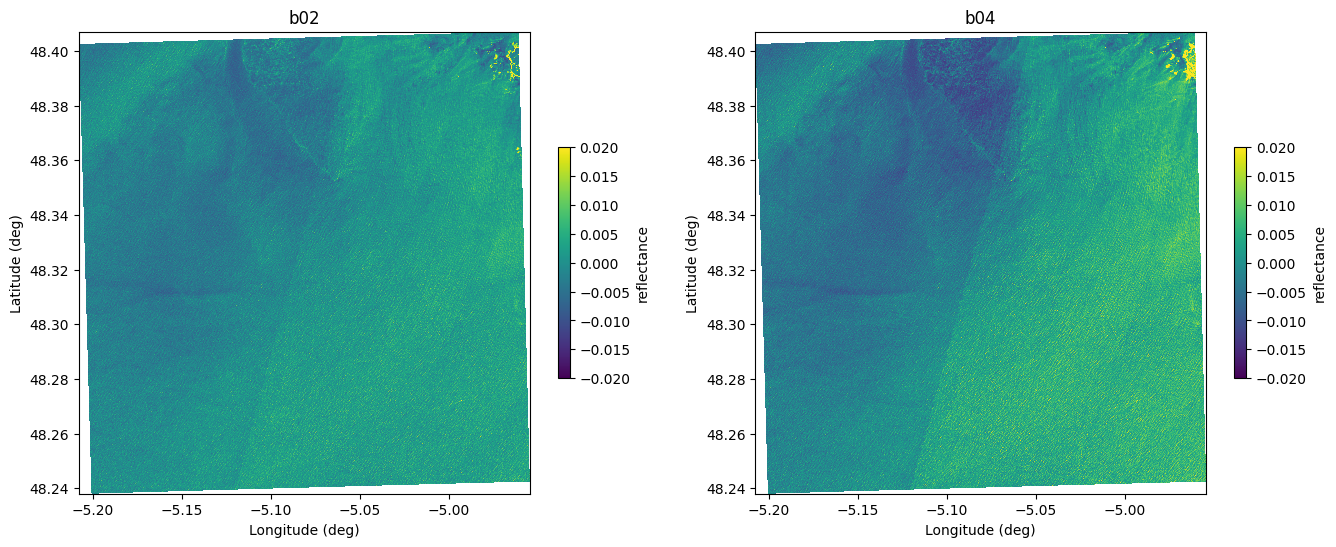

In [8]:
from foscat.Plot import plot_image_latlon

x_vals = ds.x.compute()
y_vals = ds.y.compute() 

# compute coordinate of the patch
xx, yy = np.meshgrid(x_vals, y_vals)
lon, lat = transformer.transform(xx, yy)

fig=plt.figure(figsize=(16,6))

ax=plt.subplot(1,2,1)
plot_image_latlon(fig,ax,ds["b02"].values-np.median(ds["b02"].values), lat, lon, mode="structured", shading="flat",vmin=-0.02,vmax=0.02,aspect="auto")
ax.set_title("b02")
ax=plt.subplot(1,2,2)
plot_image_latlon(fig,ax,ds["b04"].values-np.median(ds["b04"].values), lat, lon, mode="structured", shading="flat",vmin=-0.02,vmax=0.02,aspect="auto")
ax.set_title("b04")


In [9]:
import numpy as np
from foscat.Plot import conjugate_gradient_normal_equation
import dask
import xarray as xr
from xbatcher import BatchGenerator
import healpy as hp
import foscat.SphericalStencil as st
from tqdm.auto import tqdm

f=st.SphericalStencil(2**19,3)

def count_patches(xobj, input_dims, input_overlap):
    """Nombre total de fenêtres générées par xbatcher."""
    stride = {k: input_dims[k] - input_overlap.get(k, 0) for k in input_dims}
    n = 1
    for dim, win in input_dims.items():
        step = stride[dim]
        size = xobj.sizes[dim]
        # nb de positions le long de 'dim' (formule type sliding window)
        n_dim = max(0, (size - win) // step + 1)
        n *= n_dim
    return n
    
def to_healpix_dask(
    level: int,
    ds: xr.Dataset,
    *,
    pix_step: int = 128,
    transformer=None,
    prefer_kdtree: bool = True,
):
    """
    Produit une liste de dask.delayed, chacun calculant (vals, cell_ids) pour une tuile.
    """
    assert transformer is not None, "You must pass a CRS transformer with .transform(X, Y)."

    band = ds
    assert {"x", "y"} <= set(band.dims)

    pix_step = int(pix_step)         # si pix_step venait d'une string
    overlap_y = 0
    overlap_x = 0

    input_dims = {"y": int(pix_step), "x": int(pix_step)}
    input_overlap = {"y": int(overlap_y), "x": int(overlap_x)}

    # sanity-check utile
    for k, v in input_dims.items():
        if not isinstance(v, (int, np.integer)):
            raise TypeError(f"input_dims[{k}] must be int, got {type(v)} -> {v}")
    for k, v in input_overlap.items():
        if not isinstance(v, (int, np.integer)):
            raise TypeError(f"input_overlap[{k}] must be int, got {type(v)} -> {v}")
            
    gen = BatchGenerator(
        band, #.to_dataset(name="band"),
        input_dims=input_dims,
        input_overlap=input_overlap,
    )
    
    total = count_patches(band, input_dims, input_overlap)

    def _process_patch(patch_ds, x_vals, y_vals):
        # s'assure d'avoir des numpy 1D
        x_vals = x_vals.compute() if hasattr(x_vals, "compute") else np.asarray(x_vals)
        y_vals = y_vals.compute() if hasattr(y_vals, "compute") else np.asarray(y_vals)

        # compute coordinate of the patch
        xx, yy = np.meshgrid(x_vals, y_vals)
        lon, lat = transformer.transform(xx, yy)

        theta = np.deg2rad(90.0 - lat).flatten()
        phi   = np.deg2rad(lon).flatten()

        nside = 2**level

         # Compute interpolation weights and indices for projecting from HEALPix to the UTM grid
        I, W = hp.get_interp_weights(nside,theta,phi, nest=True)

        # Identify the unique HEALPix cells that will contribute to u
        cell_ids, indices = np.unique(I, return_inverse=True)

        # remove cell_ids with not enough values
        valid_cell=np.bincount(indices.flatten(),W.flatten())
        W*=valid_cell[indices]>1.0
        W/=np.sum(W,0)[None,:]
        W[~np.isfinite(W)]=0.0
        valid_cell=np.bincount(indices.flatten(),W.flatten())
        i=0
        while valid_cell[i]!=0 and i<cell_ids.shape[0]-1:
            i+=1
        I[valid_cell[indices]==0]=cell_ids[i]
        
        cell_ids = hp.ang2pix(nside, theta, phi, nest=True)

        # Identify the unique HEALPix cells that will contribute to u
        cell_ids, indices = np.unique(I, return_inverse=True)
        
        patch_1 = patch_ds["b02"].values 
        patch_2 = patch_ds["b04"].values 
        
    

        # convert each band
        vals_1 = conjugate_gradient_normal_equation(patch_1.flatten(),
                                           np.zeros([cell_ids.shape[0]]),
                                           W,
                                           indices,
                                           max_iter=100,verbose=False)
        vals_2 = conjugate_gradient_normal_equation(patch_2.flatten(),
                                           np.zeros([cell_ids.shape[0]]),
                                           W,
                                           indices,
                                           max_iter=100,verbose=False)
        
        return vals_1,vals_2, cell_ids

    data = []
    for patch in tqdm(gen, total=total, desc="Queuing patches"):
        x_slice = patch.coords["x"].data
        y_slice = patch.coords["y"].data
        l_data = _process_patch(patch, x_slice, y_slice)  # <- UN seul delayed qui contient (vals, ids)
        data.append(l_data)

    return data

In [10]:
# 1) Construire les tuiles lazy
data = to_healpix_dask(level=19, ds=ds, pix_step=256, transformer=transformer)

Queuing patches:   0%|          | 0/49 [00:00<?, ?it/s]

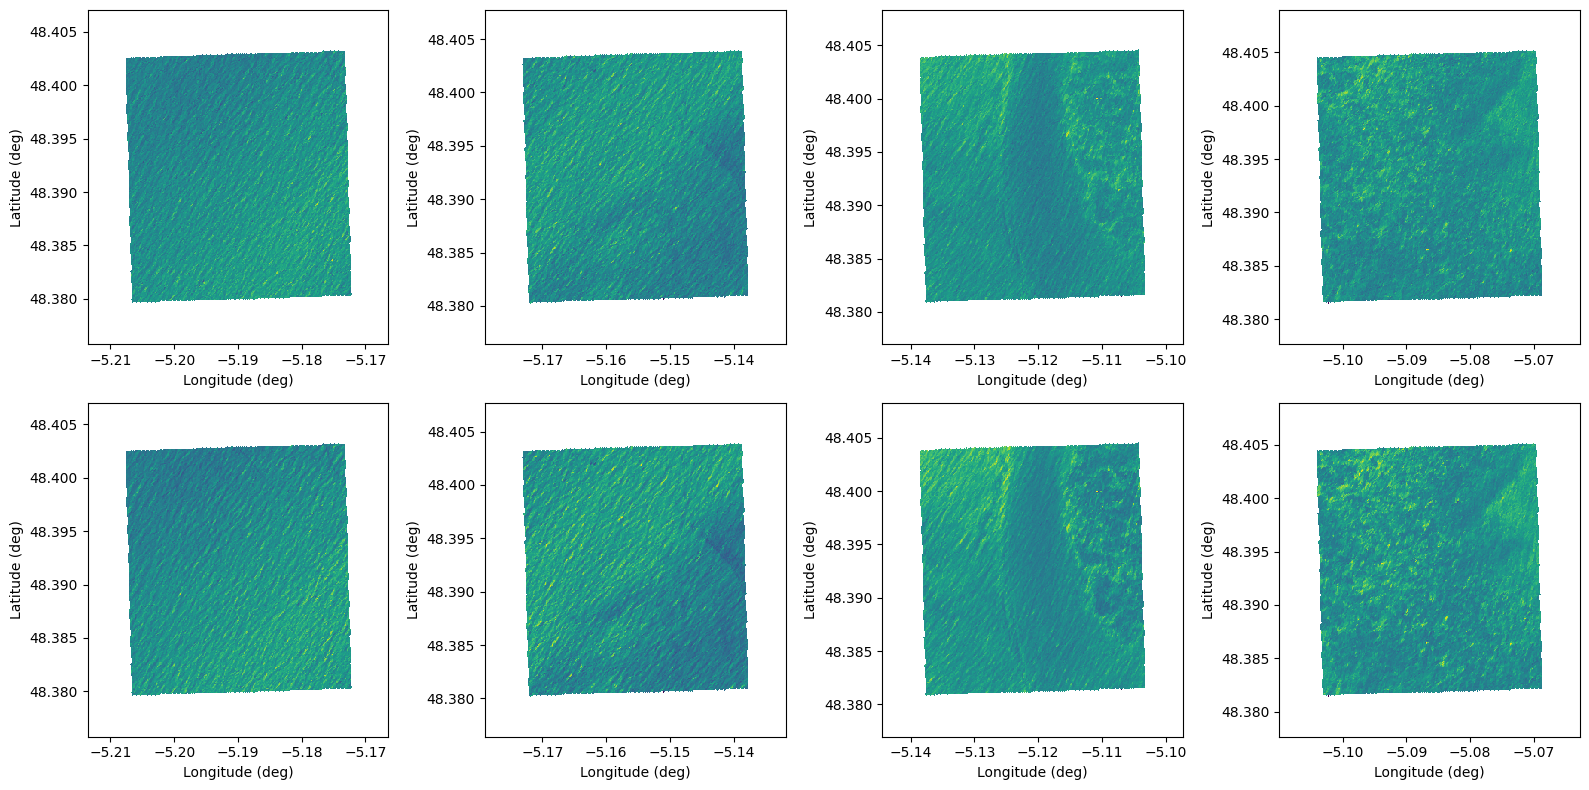

In [11]:
from foscat.Plot import lgnomproject

plt.figure(figsize=(16,8))
for k in range(4):
    lgnomproject(data[k][2],data[k][0]-np.median(data[k][0]),2**19,hold=False,sub=(2,4,1+k),vmax=0.02,vmin=-0.02)
for k in range(4):
    lgnomproject(data[k][2],data[k][1]-np.median(data[k][1]),2**19,hold=False,sub=(2,4,5+k),vmax=0.02,vmin=-0.02)

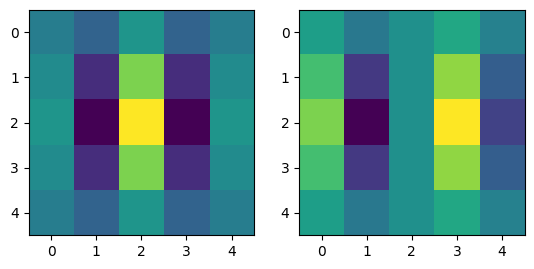

In [12]:
KERNELSZ=5

x,y=np.meshgrid(np.arange(KERNELSZ)-KERNELSZ//2,np.arange(KERNELSZ)-KERNELSZ//2)

ww=np.zeros([1,2,KERNELSZ,KERNELSZ])
ww[0,0]=np.exp(-0.4*(x**2+y**2))*np.cos(x*np.pi)
ww[0,1]=np.exp(-0.4*(x**2+y**2))*np.sin(x*np.pi)

ww[0,0]-=np.mean(ww[0,0])
ww[0,1]-=np.mean(ww[0,1])
ww/=np.sqrt(np.sum(ww[0,0]**2+ww[0,1]**2))
plt.subplot(1,2,1)
plt.imshow(ww[0,0])
plt.subplot(1,2,2)
plt.imshow(ww[0,1])

In [13]:
import foscat.SphericalStencil as st

ww=f.to_tensor(ww.reshape(1,2,KERNELSZ*KERNELSZ))

def calc_wave_spectrum(data_b02,data_b04,cell_ids,ww,number_of_orientation=8,number_of_scale=6,nside=2**19):
    
    f=st.SphericalStencil(nside,KERNELSZ,gauge_type='phi',n_gauges=number_of_orientation)

    idx_wave=np.arange(number_of_orientation)*2

    l_data_a=f.to_tensor(data_b02[None,None,:])
    l_data_b=f.to_tensor(data_b04[None,None,:])
    l_cell_ids = cell_ids
    
    l_nside=nside
    
    wave_a=np.zeros([number_of_scale,number_of_orientation*2])
    wave_b=np.zeros([number_of_scale,number_of_orientation*2])
    wave_cross_amp=np.zeros([number_of_scale,number_of_orientation*2])
    wave_cross_dir=np.zeros([number_of_scale,number_of_orientation*2])

    for k in range(number_of_scale):
        a=f.to_numpy(f.Convol_torch(l_data_a,ww,cell_ids=l_cell_ids,nside=2**19))
        b=f.to_numpy(f.Convol_torch(l_data_b,ww,cell_ids=l_cell_ids,nside=2**19))

        wave_a[k,0:number_of_orientation]=np.median(np.sqrt(a[0,idx_wave]**2+a[0,idx_wave+1]**2),-1)
        wave_b[k,0:number_of_orientation]=np.median(np.sqrt(b[0,idx_wave]**2+b[0,idx_wave+1]**2),-1)

        wave_a[k,number_of_orientation:] = wave_a[k,0:number_of_orientation]
        wave_b[k,number_of_orientation:] = wave_b[k,0:number_of_orientation]
    
        val_cross_real=a[0,idx_wave]*b[0,idx_wave]+a[0,idx_wave+1]*b[0,idx_wave+1]
        val_cross_imag=a[0,idx_wave+1]*b[0,idx_wave]-a[0,idx_wave]*b[0,idx_wave+1]
        wave_cross_amp[k,:number_of_orientation]=np.median(val_cross_real,-1)
        wave_cross_dir[k,:number_of_orientation]=np.mean(np.arctan2(val_cross_imag,val_cross_real),-1)
    
        wave_cross_amp[k,number_of_orientation:] = wave_cross_amp[k,0:number_of_orientation]
        wave_cross_dir[k,number_of_orientation:] = -wave_cross_dir[k,0:number_of_orientation]
    
        l_data_a,new_cell_ids=f.Down(l_data_a,cell_ids=l_cell_ids,nside=l_nside)
        l_data_b,new_cell_ids=f.Down(l_data_b,cell_ids=l_cell_ids,nside=l_nside)
    
        l_nside//=2
        l_cell_ids=new_cell_ids

    return wave_a,wave_b,wave_cross_amp,wave_cross_dir

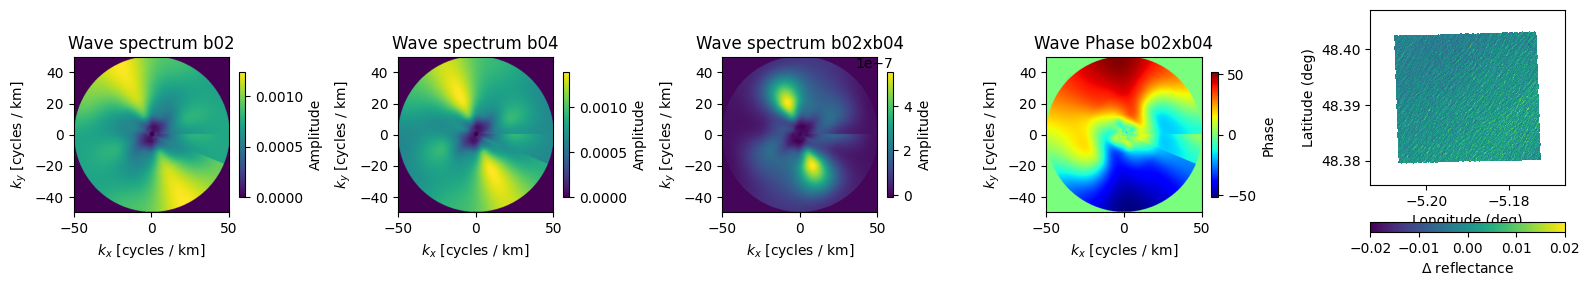

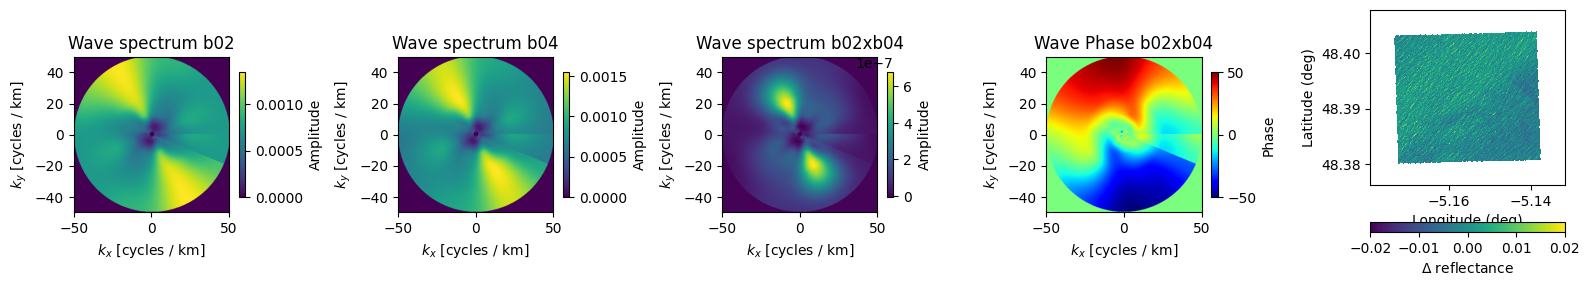

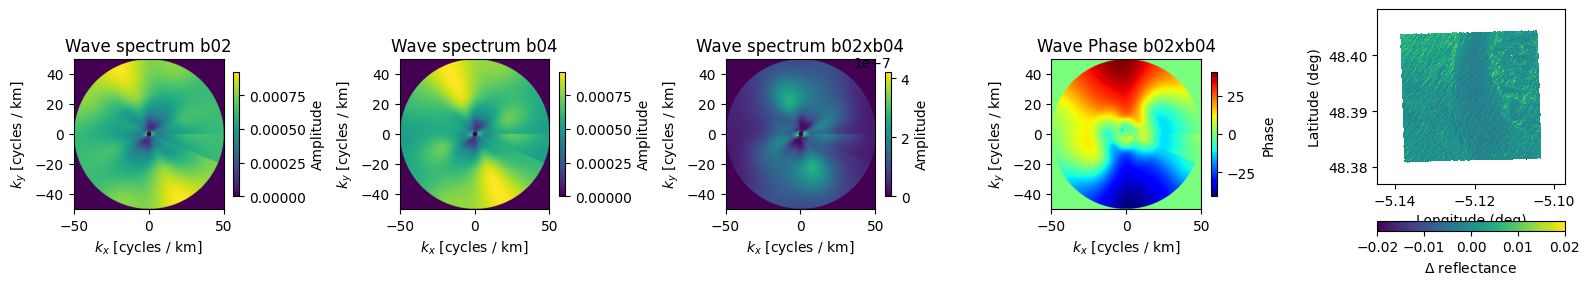

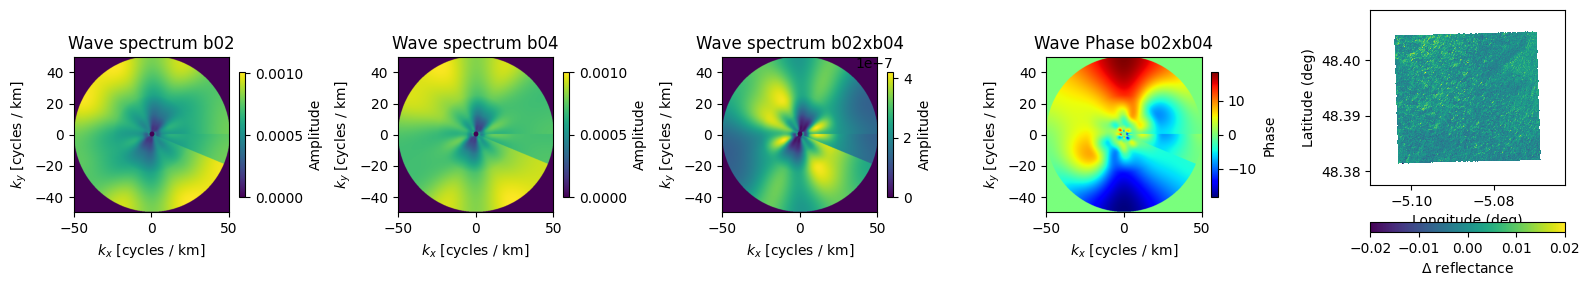

In [14]:
from foscat.Plot import plot_wave

for k in range(4):
    wave_a,wave_b,wave_cross_amp,wave_cross_dir=calc_wave_spectrum(data[k][0],data[k][1],data[k][2],ww)
    plt.figure(figsize=(16.0, 3.0))
    plt.subplot(1,5,1)
    plot_wave(wave_a,title='Wave spectrum b02')
    plt.subplot(1,5,2)
    plot_wave(wave_b,title='Wave spectrum b04')
    plt.subplot(1,5,3)
    plot_wave(wave_cross_amp,title='Wave spectrum b02xb04')
    plt.subplot(1,5,4)
    plot_wave(np.rad2deg(wave_cross_dir),unit='Phase',title='Wave Phase b02xb04',cmap="jet")

    lgnomproject(data[k][2],data[k][0]-np.median(data[k][0]),2**19,hold=False,sub=(1,5,5),vmax=0.02,vmin=-0.02,cbar=True,unit=r"$\Delta$ reflectance")

In [15]:
def to_wave_dask(
    level: int,
    ds: xr.Dataset,
    *,
    pix_step: int = 128,
    transformer=None,
    prefer_kdtree: bool = True,
):
    """
    Produit une liste de dask.delayed, chacun calculant (vals, cell_ids) pour une tuile.
    """
    assert transformer is not None, "You must pass a CRS transformer with .transform(X, Y)."

    band = ds
    assert {"x", "y"} <= set(band.dims)

    pix_step = int(pix_step)         # si pix_step venait d'une string
    overlap_y = 0
    overlap_x = 0

    input_dims = {"y": int(pix_step), "x": int(pix_step)}
    input_overlap = {"y": int(overlap_y), "x": int(overlap_x)}

    # sanity-check utile
    for k, v in input_dims.items():
        if not isinstance(v, (int, np.integer)):
            raise TypeError(f"input_dims[{k}] must be int, got {type(v)} -> {v}")
    for k, v in input_overlap.items():
        if not isinstance(v, (int, np.integer)):
            raise TypeError(f"input_overlap[{k}] must be int, got {type(v)} -> {v}")

    gen = BatchGenerator(
        band, 
        input_dims=input_dims,
        input_overlap=input_overlap,
    )

    total = count_patches(band, input_dims, input_overlap)
    
    def _process_patch(patch_ds, x_vals, y_vals):
        # s'assure d'avoir des numpy 1D
        x_vals = x_vals.compute() if hasattr(x_vals, "compute") else np.asarray(x_vals)
        y_vals = y_vals.compute() if hasattr(y_vals, "compute") else np.asarray(y_vals)

        # compute coordinate of the patch
        xx, yy = np.meshgrid(x_vals, y_vals)
        lon, lat = transformer.transform(xx, yy)

        theta = np.deg2rad(90.0 - lat).flatten()
        phi   = np.deg2rad(lon).flatten()

        nside = 2**level

         # Compute interpolation weights and indices for projecting from HEALPix to the UTM grid
        I, W = hp.get_interp_weights(nside,theta,phi, nest=True)

        # Identify the unique HEALPix cells that will contribute to u
        cell_ids, indices = np.unique(I, return_inverse=True)

        # remove cell_ids with not enough values
        valid_cell=np.bincount(indices.flatten(),W.flatten())
        W*=valid_cell[indices]>1.0
        W/=np.sum(W,0)[None,:]
        W[~np.isfinite(W)]=0.0
        valid_cell=np.bincount(indices.flatten(),W.flatten())
        i=0
        while valid_cell[i]!=0 and i<cell_ids.shape[0]-1:
            i+=1
        I[valid_cell[indices]==0]=cell_ids[i]
        
        cell_ids = hp.ang2pix(nside, theta, phi, nest=True)

        # Identify the unique HEALPix cells that will contribute to u
        cell_ids, indices = np.unique(I, return_inverse=True)
        
        patch_1 = patch_ds["b02"].values 
        patch_2 = patch_ds["b04"].values 
        
        # convert each band
        vals_1 = conjugate_gradient_normal_equation(patch_1.flatten(),
                                           np.zeros([cell_ids.shape[0]]),
                                           W,
                                           indices,
                                           max_iter=100,verbose=False)
        vals_2 = conjugate_gradient_normal_equation(patch_2.flatten(),
                                           np.zeros([cell_ids.shape[0]]),
                                           W,
                                           indices,
                                           max_iter=100,verbose=False)

        wave_a,wave_b,wave_cross_amp,wave_cross_dir=calc_wave_spectrum(vals_1,vals_2,cell_ids,ww)
        
        return wave_a,wave_b,wave_cross_amp,wave_cross_dir,np.median(lon),np.median(lat)

    results = []
    for patch in tqdm(gen, total=total, desc="Queuing patches"):
        x_slice = patch.coords["x"].data
        y_slice = patch.coords["y"].data
        all_result = _process_patch(patch, x_slice, y_slice)  # <- UN seul delayed qui contient (vals, ids)
        results.append(all_result)

    return results

In [16]:
# 1) Construire les tuiles lazy
result = to_wave_dask(level=19, ds=ds, pix_step=128, transformer=transformer)

Queuing patches:   0%|          | 0/196 [00:00<?, ?it/s]

In [17]:
# compute the coordinate of the results
center_lon=np.array([k[-2] for k in result])
center_lat=np.array([k[-1] for k in result])

Text(0.5, 1.0, 'b02')

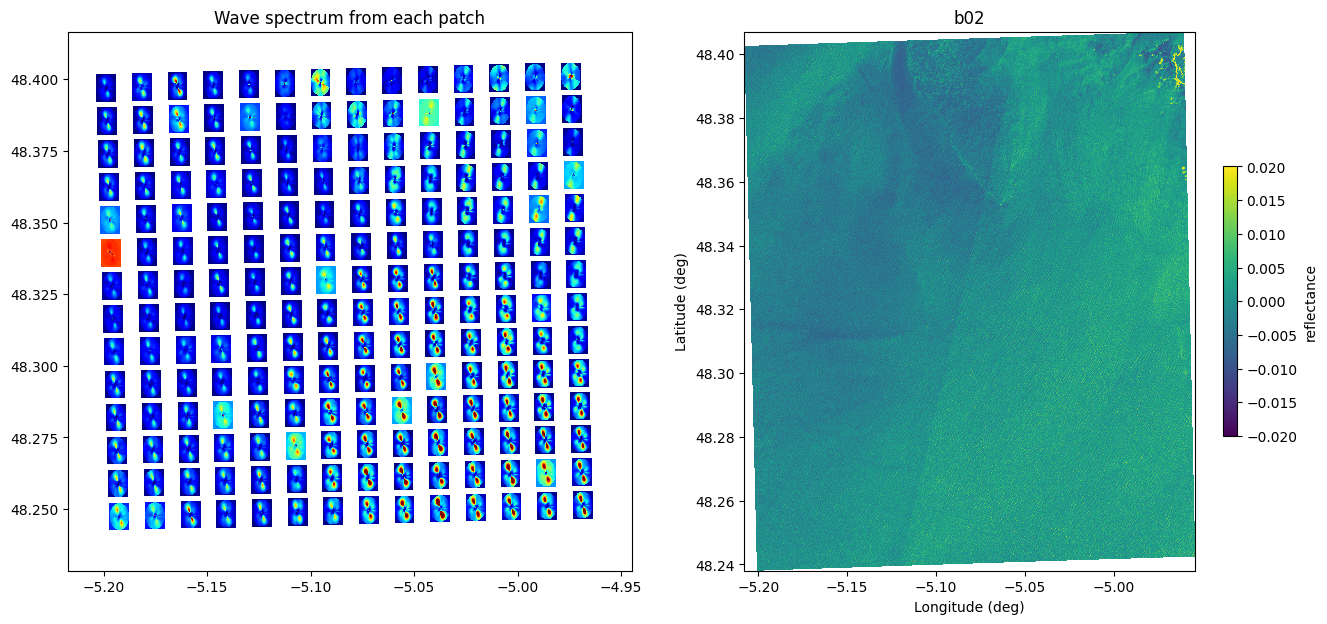

In [18]:
from foscat.Plot import lonlat_edges_from_ref,spectrum_polar_to_cartesian

fig=plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
for k in range(center_lon.shape[0]):
    img, kx, ky = spectrum_polar_to_cartesian(
                result[k][2],
                scales=2**np.arange(result[k][2].shape[0]),                 # tailles croissantes
                scale_kind="size",            # conversion automatique vers fréquence
                size_to_freq_factor=50.0,      # cycles / (unit of size) (Sentinel-2 10m résolution ~to 20m resoltuion for smaller scale; equiv. 50 cycles/km
                method="bicubic",
                n_pixels=64,
            )
    
    # Known reference: image center at ~Brest (just an example)
    ref_lat = center_lat[k]
    ref_lon = center_lon[k]
    dlon, dlat = 1.5E-4,1.5E-4   # 0.01° par pixel (≈ 1.1 km en lat)

    lon_e, lat_e = lonlat_edges_from_ref(img.shape, ref_lon, ref_lat, dlon, dlat, anchor="center")

    plt.pcolormesh(lon_e, lat_e, img, cmap='jet', shading="flat",vmax=1E-6)
    
plt.title("Wave spectrum from each patch")
plt.xlim(lon.min()-64*dlon,lon.max()+64*dlon)
plt.ylim(lat.min()-64*dlat,lat.max()+64*dlat)

x_vals = ds.x.compute()
y_vals = ds.y.compute() 
# compute coordinate of the patch
xx, yy = np.meshgrid(x_vals, y_vals)
lon, lat = transformer.transform(xx, yy)
ax=plt.subplot(1,2,2)
plot_image_latlon(fig,ax,ds["b02"].values-np.median(ds["b02"].values), lat, lon, mode="structured", shading="flat",vmin=-0.02,vmax=0.02,aspect="auto")
ax.set_title("b02")